In [46]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import Lambda
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM, GradCAMpp, SmoothGradCAMpp

In [3]:
def fix_sep(path):
    '''
    fixes the path separator to the current OS
    '''
    not_sep = {'\\': '/', '/': '\\'}

    if not_sep[os.sep] in path:
        return path.replace(not_sep[os.sep], os.sep)
    else:
        return path

class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images

    Args:
    dataframe: pandas dataframe containing image paths and labels
    transform: torchvision.transforms.Compose object for image augmentation for training/testing
    transform_og: torchvision.transforms.Compose object for image augmentation for visualizing original images
    return_og: bool, if True, returns original image along with transformed image

    Returns:
    image1: transformed image
    label: label of the image
    image2: original image (if return_og is True)
    image_name: image name (if return_img_name is True)
    '''
    def __init__(self, dataframe, transform=None, transform_og=None, return_og=False, return_img_name=False):   
        self.dataframe = dataframe
        self.transform = transform
        self.transform_og = transform_og
        self.return_og = return_og
        self.return_img_name = return_img_name

        if self.return_og:
            assert self.transform_og is not None, 'transform_og must be provided if return_og is True'

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('..',fix_sep(self.dataframe.iloc[idx, 0]))

        label = self.dataframe.iloc[idx, 1]

        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform :
            image1 = self.transform(image)
        
        if self.return_og:
           image2 = self.transform_og(image)
           if self.return_img_name:
               return image1, label, image2, img_name
           else:
               return image1, label, image2
        else:
           if self.return_img_name:
               return image1, label, img_name
           else:
               return image1, label

        

In [4]:
#generate mask bounding box around the mask leave some margin
#also generate center point of the mask
import cv2

def mask_bounding_box(mask,margin=5):
    '''
    mask: numpy array of the mask
    margin: margin around the bounding box
    '''
    #convert to grayscale if not
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif len(mask.shape) == 2:
        gray = mask
    else:
        raise ValueError("Unsupported image format")
    
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box
    largest_contour=max(contours,key=cv2.contourArea)

    x,y,w,h=cv2.boundingRect(largest_contour)
    #where x,y are the top left corner of the bounding box

    #add margin to the bounding box
    x_min=x-margin if x-margin > 0 else 0
    y_min=y-margin if y-margin > 0 else 0
    x_max=x+w+margin if x+w+margin < mask.shape[1] else mask.shape[1]
    y_max=y+h+margin if y+h+margin < mask.shape[0] else mask.shape[0]
    #get center point
    center_x=x+w//2
    center_y=y+h//2
    return x_min,y_min,x_max,y_max,center_x,center_y


In [5]:
# Load the dataframe
df_path = os.path.join('..','Dataset_BUSI_with_GT','dataset.csv')
df = pd.read_csv(df_path)

# df_abnormal = df[df['true_label_num'].isin([1,2])].copy()
# df_abnormal['true_label_num']-=1

# df_normal_abnormal = df.copy()
# df_normal_abnormal['true_label_num'] = df_normal_abnormal['true_label_num'].apply(lambda x: 0 if x == 0 else 1)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
#train_df_normal_abnormal, val_df_normal_abnormal = train_test_split(df_normal_abnormal, test_size=0.2, random_state=42)


In [6]:
MODEL_SAVE_DIR = 'ResNet18_try'
best_model = torch.load(os.path.join(MODEL_SAVE_DIR,'model_best.pt'))
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
from sklearn.metrics import classification_report

def get_classification_report(model,val_dataloader):
    # put model in eval mode
    model.eval()
    model.to(DEVICE)

    # keep list of true and predicted labels
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, (img, label,og_img,img_path) in enumerate(val_dataloader):
            # send image to device
            img = img.to(DEVICE)    # [batch_size, 3, 256, 256]
            label = label.to(DEVICE)   # [batch_size,]

            # forward pass
            output = model(img)    # [batch_size, 1]

            # y_true
            y_true.extend(label.cpu().numpy().tolist())

            # y_pred
            y_pred.extend(torch.where(output>=0,1,0).detach().cpu().numpy())

            
    print('Classification Report')
    print(classification_report(y_true, y_pred))

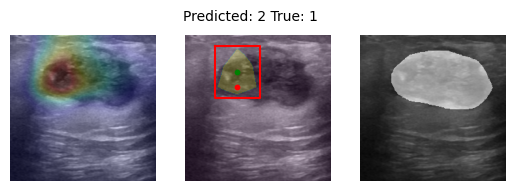

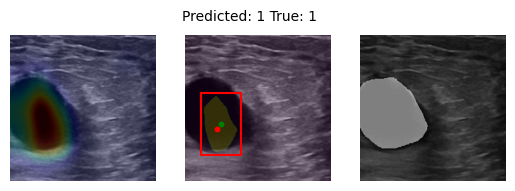

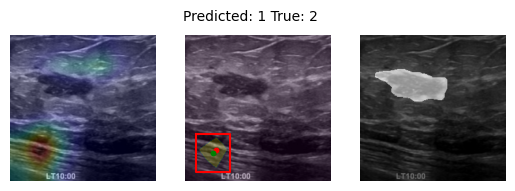

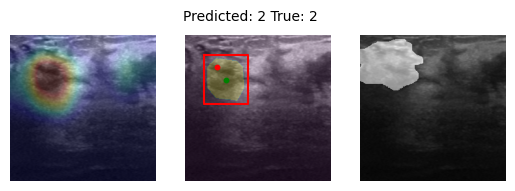

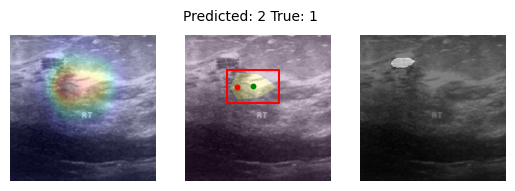

In [65]:
# HYPERPARAMS
VAL_DF = val_df
TRAIN_DF = train_df
NUM_IMG = 5
BOX_MARGIN = 5


transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
        # Normalize the image using the mean and standard deviation of the ImageNet dataset
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transforms_og = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    ])

val_dataset_og = UltrasoundDataset(VAL_DF, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
val_dataloader_og = DataLoader(val_dataset_og, batch_size=1, shuffle=True)

train_dataset_og = UltrasoundDataset(TRAIN_DF, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
train_dataloader_og = DataLoader(train_dataset_og, batch_size=1, shuffle=True)

best_model.to(DEVICE)
best_model.eval()    

# get_classification_report(best_model,val_dataloader_og


i=0
with GradCAM(best_model) as cam_extractor:
    for img, label,og_img, img_path in val_dataloader_og:
        i+=1
        img = img[:1].to(DEVICE)
        label = label.to(DEVICE)
        out = best_model(img)

        if len(((out.squeeze(-1)).shape))==1:
            activation_map = cam_extractor(0, out)
        else:
            activation_map = cam_extractor(out.squeeze(0).argmax().item(),out)
        
        fig,ax = plt.subplots(1,3)

        result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.8)
        ax[0].imshow(result)
        ax[0].axis('off')

        #thresholding the activation map to get the mask
        threshold = 0.8
        activation_map= torch.stack(activation_map)
           #print('activation map shape:',activation_map.shape)
        activation_map = torch.nn.functional.interpolate(activation_map, size=(224,224), mode='bilinear', align_corners=False)
           
           #location of maximum value in the activation map
           
        x_loc,y_loc=np.where(activation_map[0].squeeze(0).cpu().numpy() == activation_map[0].squeeze(0).cpu().numpy().max())
           
           
           
           #thresholding
        mask = np.where(activation_map[0].squeeze(0).cpu().numpy() > threshold, 1, 0)
        mask=mask.astype(np.uint8)

        mask_3d = np.stack([mask]*3,axis=-1)

        try:
                x_min,y_min,x_max,y_max,center_x,center_y=mask_bounding_box(mask_3d,margin=BOX_MARGIN)
        except:
                print('Error in mask bounding box')
                continue


        ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
        ax[1].imshow(mask,alpha=0.2)
        ax[1].scatter(y_loc,x_loc,c='r',s=10)
        ax[1].scatter(center_x,center_y,c='g',s=10)
        ax[1].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
        ax[1].axis('off') 

        if len(((out.squeeze(-1)).shape))==1:
            print_pred_label= 1 if out>=0 else 0
            print('here')
        else:
            print_pred_label= torch.argmax(out,-1).item()
            
        
        img_path=fix_sep(img_path[0])
        #remove .png and add _mask.png
        img_path=img_path[:-4]+'_mask.png'
        gt_mask = Image.open(img_path)
        gt_mask = transforms_og(gt_mask)
        
        ax[2].imshow(og_img[0].permute(1, 2, 0).cpu().numpy())
        ax[2].imshow(gt_mask.permute(1, 2, 0).cpu().numpy(),alpha=0.5); ax[2].axis('off')
            
        plt.suptitle(f'Predicted: {print_pred_label} True: {label.item()}',y=0.7, fontsize=10)
        
        
            
        plt.show()
        
    
        
        #print(f'Image path: {img_path}')
        if i==NUM_IMG:
            break